## 1) Data Pre-Processing and Cleaning:

### Libraries import

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import scipy as scp

sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os 
print(os.listdir())

pd.set_option('float_format', '{:f}'.format)

['sub_ran_for_all_params_100.csv', '.DS_Store', 'sub_lin_reg_sub_params.csv', 'sub_ran_for_sub_params_100.csv', 'Submission_Book.ipynb', 'Test_Book.ipynb', '1474744.csv', 'all', 'sub_ran_for_sub_params_20.csv', 'sub_lin_reg_all_params4.csv', 'sub_ran_for_all_params_20_1.csv', 'sub_lin_reg_all_params2.csv', 'sub_lin_reg.csv', 'sub_ran_for_all_params_20.csv', 'sub_lin_reg_all_params3.csv', '.ipynb_checkpoints', 'sub_lin_reg_all_params.csv', 'plots']


### Read data and create replica for processing

In [2]:
training = pd.read_csv('all/train.csv', nrows = 5000000)
test = pd.read_csv('all/test.csv')

training_copy = training.copy()
test_copy = test.copy()

#### Create a random sample to compare with the training set under consideration

In [3]:
import random

n = 55423856 # number of records in dataset
s = 5000000  # required sample size
filename = "all/train.csv"
skip = random.sample(range(1,n),n-1-s)
random_training = pd.read_csv(filename, skiprows=skip)

In [4]:
training_copy.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5000000.000000,5000000.000000,5000000.000000,4999964.000000,4999964.000000,5000000.000000
mean,11.340802,-72.506778,39.919745,-72.506519,39.917255,1.684695
std,9.820175,12.809700,8.963509,12.847770,9.486767,1.331854
min,-100.000000,-3426.608950,-3488.079513,-3412.653087,-3488.079513,0.000000
25%,6.000000,-73.992062,40.734909,-73.991393,40.734042,1.000000
50%,8.500000,-73.981812,40.752635,-73.980158,40.753150,1.000000
75%,12.500000,-73.967110,40.767115,-73.963672,40.768110,2.000000
max,1273.310000,3439.425565,3310.364462,3457.622350,3345.917353,208.000000


In [5]:
random_training.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5000001.000000,5000001.000000,5000001.000000,4999965.000000,4999965.000000,5000001.000000
mean,11.334788,-72.516294,39.924942,-72.512033,39.926639,1.685805
std,9.774418,12.861492,9.602467,12.843907,9.629323,1.323249
min,-105.000000,-3348.349457,-3474.111983,-3348.349457,-3474.111983,0.000000
25%,6.000000,-73.992081,40.734930,-73.991389,40.734049,1.000000
50%,8.500000,-73.981818,40.752639,-73.980133,40.753175,1.000000
75%,12.500000,-73.967090,40.767112,-73.963643,40.768109,2.000000
max,698.160000,3454.854513,3361.254635,3440.830317,3400.391603,208.000000


### Data cleaning

Text(0.5,1,'Distribution of Fare Amount')

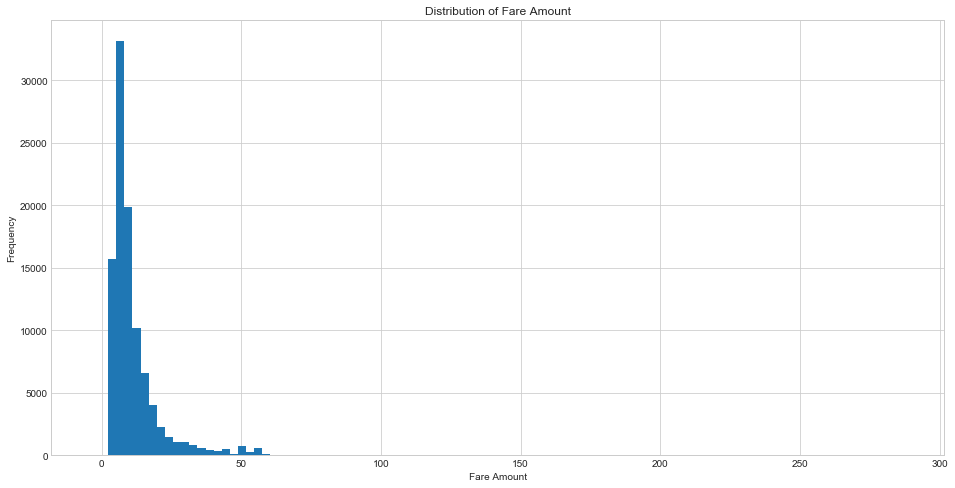

In [6]:
## Plot graph showing frequency of fare amount to understand the fare distribution initially

training_copy.sample(100000).fare_amount.hist(bins=100, figsize = (16,8))
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Fare Amount")


Text(0.5,1,'Distribution of Number of Passengers')

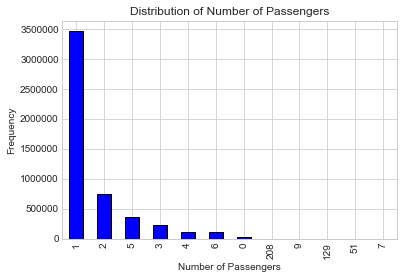

In [7]:
## Plot graph showing frequency of passenger count initially

training_copy['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k')
plt.xlabel("Number of Passengers")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Passengers")


In [8]:
def clean_data(temp):
    
    
    # drop null values
    temp.dropna(inplace=True)
    
    # drop fare values less than 2.5$ and more than 80$
    temp.drop(index=temp[temp['fare_amount'] < 2.5].index,inplace=True)
    temp.drop(index=temp[temp["fare_amount"] > 80].index,inplace=True)
    
    # drop passenger counts less than 1 and more than 6
    temp.drop(index=temp[temp['passenger_count'] > 6].index,inplace=True)
    temp.drop(index=temp[temp['passenger_count'] < 1].index,inplace=True)
    
    # drop pickup and dropoff longitudes values outside the bounds of -72.5 and -74.5
    temp.drop(index=temp[(temp.pickup_longitude > -72.5)].index,inplace=True)
    temp.drop(index=temp[(temp.pickup_longitude < -74.5)].index,inplace=True)
    temp.drop(index=temp[(temp.dropoff_longitude > -72.5)].index,inplace=True)
    temp.drop(index=temp[(temp.dropoff_longitude < -74.5)].index,inplace=True)
    
    # drop pickup and dropoff latitudes values outside the bounds of 40 and 42
    temp.drop(index=temp[(temp.pickup_latitude > 42)].index,inplace=True)
    temp.drop(index=temp[(temp.pickup_latitude < 40)].index,inplace=True)
    temp.drop(index=temp[(temp.dropoff_latitude > 42)].index,inplace=True)
    temp.drop(index=temp[(temp.dropoff_latitude < 40)].index,inplace=True)
    
    # drop entries with same pickup and drop location
    temp.drop(index=temp[(temp.pickup_latitude == temp.dropoff_latitude) & (temp.pickup_longitude == temp.dropoff_longitude)].index,inplace=True)
    
    return temp


In [9]:
training_copy = clean_data(training_copy.copy())

In [10]:
training_copy.shape

(4820856, 8)

## 2) Creating features for computing correlation and visualization

### Computing the euclidean distance (sqrt((x2-x1)^2 + (y2-y1)^2))

In [11]:
training_copy['euclidean_dist'] = (abs(training_copy['pickup_longitude'] - training_copy['dropoff_longitude'])**2 + abs(training_copy['pickup_latitude'] - training_copy['dropoff_latitude'])**2)**(1/2)
test_copy['euclidean_dist'] = (abs(test_copy['pickup_longitude'] - test_copy['dropoff_longitude'])**2 + abs(test_copy['pickup_latitude'] - test_copy['dropoff_latitude'])**2)**(1/2)

training_copy['longitude_diff'] = (training_copy['dropoff_longitude'] - training_copy['pickup_longitude']).abs()
training_copy['latitude_diff'] = (training_copy['dropoff_latitude'] - training_copy['pickup_latitude']).abs()

test_copy['longitude_diff'] = (test_copy['dropoff_longitude'] - test_copy['pickup_longitude']).abs()
test_copy['latitude_diff'] = (test_copy['dropoff_latitude'] - test_copy['pickup_latitude']).abs()

### Computing the haversine distance in kilometers

In [12]:
# Radius of the earth in kilometers
R = 6378

def haversine_calc(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

training_copy['haversine_dist'] =  haversine_calc(training_copy['pickup_longitude'], training_copy['pickup_latitude'],
                         training_copy['dropoff_longitude'], training_copy['dropoff_latitude'])
test_copy['haversine_dist'] =  haversine_calc(test_copy['pickup_longitude'], test_copy['pickup_latitude'],
                         test_copy['dropoff_longitude'], test_copy['dropoff_latitude']) 

In [13]:
# Also, we drop entries from dataset for which haversine distance after rounding to 3 decimals is zero

training_copy['haversine_dist'] = training_copy['haversine_dist'].round(3)
training_copy.drop(training_copy[(training_copy.haversine_dist == 0)].index,inplace=True)

test_copy['haversine_dist'] = test_copy['haversine_dist'].round(3)
test_copy.drop(test_copy[(test_copy.haversine_dist == 0)].index,inplace=True)


### Computing the time of day from pickup datetime

In [14]:
training_copy['pickup_datetime']  = pd.to_datetime(training_copy['pickup_datetime']) # convert datetime to UTC standard time
test_copy['pickup_datetime'] = pd.to_datetime(test_copy['pickup_datetime']) # convert datetime to UTC standard

training_copy['year'] = training_copy['pickup_datetime'].dt.year
training_copy['month'] = training_copy['pickup_datetime'].dt.month
training_copy['day'] = training_copy['pickup_datetime'].dt.dayofweek
training_copy['hour'] = training_copy['pickup_datetime'].dt.hour

test_copy['year'] = test_copy['pickup_datetime'].dt.year
test_copy['month'] = test_copy['pickup_datetime'].dt.month
test_copy['day'] = test_copy['pickup_datetime'].dt.dayofweek
test_copy['hour'] = test_copy['pickup_datetime'].dt.hour



### a) Euclidean distance of the ride and the taxi fare

In [15]:
training_copy['euclidean_dist'].corr(training_copy['fare_amount'],method='pearson')


0.8542338949513941

### b) Time of day and distance traveled

In [16]:
training_copy['hour'].corr(training_copy['haversine_dist'],method='pearson')


-0.028106602409080042

### c) Time of day and the taxi fare

In [17]:
training_copy['hour'].corr(training_copy['fare_amount'],method='pearson')


-0.01711993061809257

## 3) Creating visualizations for relation between features in (2)

#### Create fare bins of range 5 from 0 to 50 i.e (0,5], (5,10], ..., [45+]

In [18]:
# Snippet taken from https://www.kaggle.com/willkoehrsen/a-walkthrough-and-a-challenge by Will Koehrsen

training_copy['fare_bin'] = pd.cut(training_copy['fare_amount'], bins = list(range(0, 50, 5))).astype(str)
training_copy.loc[training_copy['fare_bin'] == 'nan', 'fare_bin'] = '[45+]'

training_copy.loc[training_copy['fare_bin'] == '(5, 10]', 'fare_bin'] = '(05, 10]'


### a) Euclidean distance of the ride and the taxi fare

Text(0.5,1,'Average Euclidean Distance by Fare Bin')

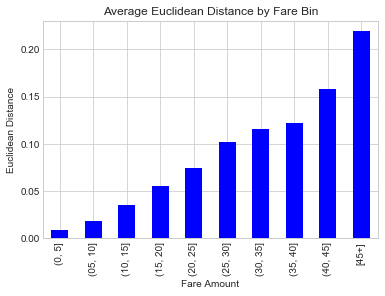

In [19]:
training_copy.groupby('fare_bin')['euclidean_dist'].median().plot.bar(color = 'b')
plt.xlabel("Fare Amount")
plt.ylabel("Euclidean Distance")
plt.title("Average Euclidean Distance by Fare Bin")


### b) Time of day and distance traveled

Text(0.5,1,'Average Distance Travelled by Time of Day')

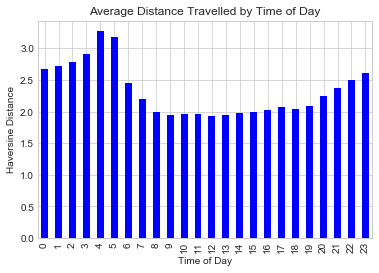

In [20]:
training_copy.groupby('hour')['haversine_dist'].median().plot.bar(color = 'b')
plt.xlabel("Time of Day")
plt.ylabel("Haversine Distance")
plt.title("Average Distance Travelled by Time of Day")


Text(0.5,1,'Distribution of Distance Travelled throughout the Day')

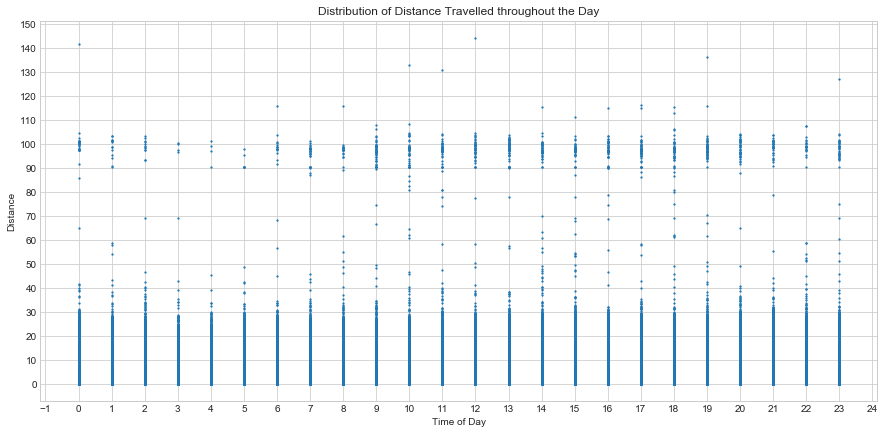

In [21]:
import matplotlib.ticker as ticker

plt.figure(figsize=(15,7))
plt.scatter(x=training_copy['hour'], y=training_copy['haversine_dist'], s=1.5)
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xlabel("Time of Day")
plt.ylabel("Distance")
plt.title("Distribution of Distance Travelled throughout the Day")


### c) Time of day and the taxi fare(for same distance - 0.01 km)

In [22]:
# For visualizing relation between time of day and fare we need distance to be fixed for accurate results
data_sample = training_copy[training_copy.haversine_dist == 0.001000]


Text(0.5,1,'Average Fare Amount by Time of Day for same distance')

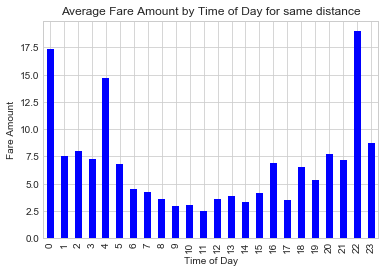

In [23]:
data_sample.groupby('hour')['fare_amount'].median().plot.bar(color = 'b')
plt.xlabel("Time of Day")
plt.ylabel("Fare Amount")
plt.title("Average Fare Amount by Time of Day for same distance")


Text(0.5,1,'Distribution of Fare Amount throughout the Day for same distance')

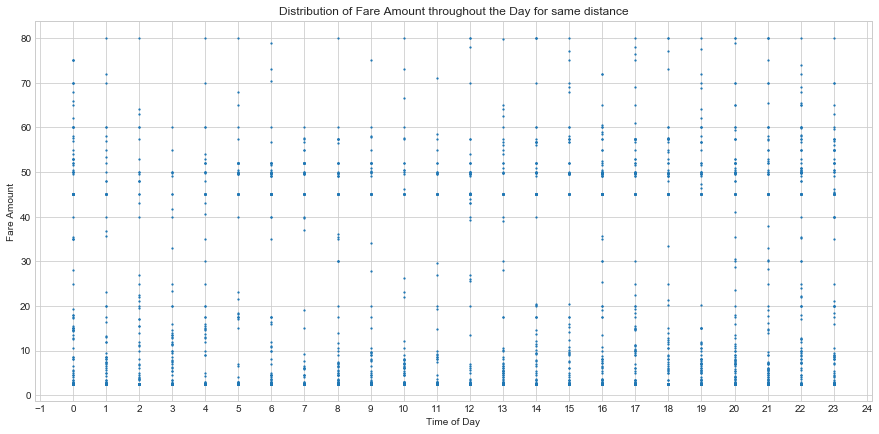

In [24]:
plt.figure(figsize=(15,7))
plt.scatter(x=data_sample['hour'], y=data_sample['fare_amount'], s=1.5)
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel("Time of Day")
plt.ylabel("Fare Amount")
plt.title("Distribution of Fare Amount throughout the Day for same distance")


## 4) Creating an interesting plot and taking insights from it

### Below is a plot showing variation in frequency of rides for each day of the week

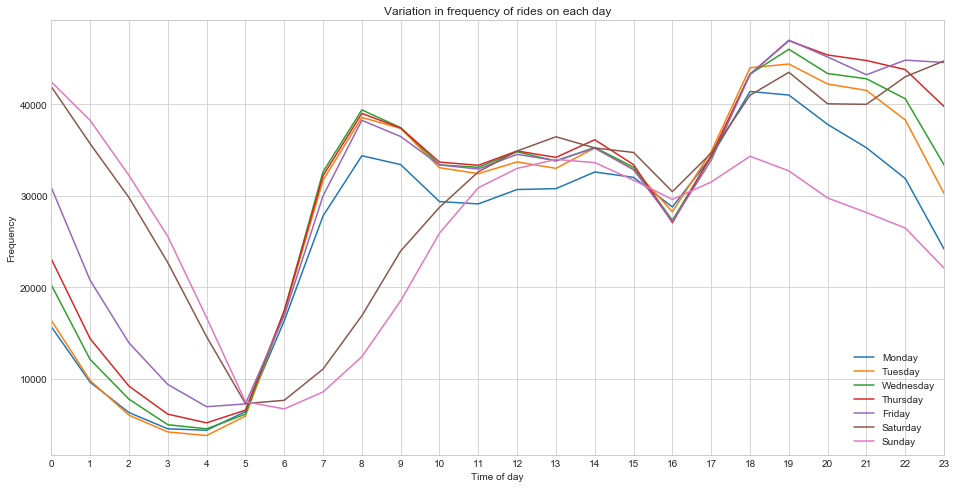

In [25]:
import matplotlib.ticker as ticker

plt.figure(figsize=(16,8))
plt.plot(training_copy[training_copy['day'] == 0].groupby('hour')['fare_amount'].count(),label="Monday")
plt.plot(training_copy[training_copy['day'] == 1].groupby('hour')['fare_amount'].count(),label="Tuesday")
plt.plot(training_copy[training_copy['day'] == 2].groupby('hour')['fare_amount'].count(),label="Wednesday")
plt.plot(training_copy[training_copy['day'] == 3].groupby('hour')['fare_amount'].count(),label="Thursday")
plt.plot(training_copy[training_copy['day'] == 4].groupby('hour')['fare_amount'].count(),label="Friday")
plt.plot(training_copy[training_copy['day'] == 5].groupby('hour')['fare_amount'].count(),label="Saturday")
plt.plot(training_copy[training_copy['day'] == 6].groupby('hour')['fare_amount'].count(),label="Sunday")
plt.legend(loc="lower right")
plt.xlim([0,23])
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title("Variation in frequency of rides on each day")
plt.xlabel("Time of day")
plt.ylabel("Frequency")
plt.show()

## 5) Generating additional features for training model

#### Most of the additional features to be used for training have been created in the previous steps and used for visualization and/or computation of certain values

### To handle airport entries, we create certain additional parameters to identify these kind of entries

In [26]:
LAT_JFK = 40.6441666
LON_JFK = -73.7822222
LAT_LAGU = 40.7747222
LON_LAGU = -73.8719444
LAT_NEW = 40.6897222
LON_NEW = -74.175

#**** FROM/TO JFK ****#

training_copy['JFK_to_dropoff'] = haversine_calc(training_copy['dropoff_latitude'], LAT_JFK, training_copy['dropoff_longitude'], LON_JFK)
training_copy['JFK_to_pickup'] = haversine_calc(LAT_JFK, training_copy['pickup_latitude'], LON_JFK, training_copy['pickup_longitude'])

test_copy['JFK_to_dropoff'] = haversine_calc(test_copy['dropoff_latitude'], LAT_JFK, test_copy['dropoff_longitude'], LON_JFK)
test_copy['JFK_to_pickup'] = haversine_calc(LAT_JFK, test_copy['pickup_latitude'], LON_JFK, test_copy['pickup_longitude'])


#**** FROM/TO LAGUARDIA ****#

training_copy['LAGU_to_dropoff'] = haversine_calc(training_copy['dropoff_latitude'], LAT_LAGU, training_copy['dropoff_longitude'], LON_LAGU)
training_copy['LAGU_to_pickup'] = haversine_calc(LAT_LAGU, training_copy['pickup_latitude'], LON_LAGU, training_copy['pickup_longitude'])

test_copy['LAGU_to_dropoff'] = haversine_calc(test_copy['dropoff_latitude'], LAT_LAGU, test_copy['dropoff_longitude'], LON_LAGU)
test_copy['LAGU_to_pickup'] = haversine_calc(LAT_LAGU, test_copy['pickup_latitude'], LON_LAGU, test_copy['pickup_longitude'])


#**** FROM/TO NEWARK ****#

training_copy['NEW_to_dropoff'] = haversine_calc(training_copy['dropoff_latitude'], LAT_NEW, training_copy['dropoff_longitude'], LON_NEW)
training_copy['NEW_to_pickup'] = haversine_calc(LAT_NEW, training_copy['pickup_latitude'], LON_NEW, training_copy['pickup_longitude'])

test_copy['NEW_to_dropoff'] = haversine_calc(test_copy['dropoff_latitude'], LAT_NEW, test_copy['dropoff_longitude'], LON_NEW)
test_copy['NEW_to_pickup'] = haversine_calc(LAT_NEW, test_copy['pickup_latitude'], LON_NEW, test_copy['pickup_longitude'])


## 6) Setup a simple Linear Regression model

#### We setup a simple linear regression model taking the following parameters : { haversine_dist , longitude_diff ,  latitude_diff  }

#### Initialize the model

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lin_reg = LinearRegression()

#### Create training and validation set from the training dataset

In [28]:
training_sample = training_copy.copy()

X_train, X_valid, y_train, y_valid = train_test_split(training_sample, np.array(training_sample['fare_amount']), 
                                                      stratify = training_sample['fare_bin'],
                                                      random_state = 1, test_size = 1000000)

# stratify ensure uniform distribution of fares in both trianing and validation set

#### Train and evaluate the model

#### First we create a function to compute root mean square error value inorder to compute the preformance of model

In [29]:
# Code snippet used from https://www.kaggle.com/willkoehrsen/a-walkthrough-and-a-challenge by Will Koehrsen

from sklearn.metrics import mean_squared_error


def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    
    return train_rmse, valid_rmse

def evaluate(model, X_train, X_valid, y_train, y_valid, features):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse = metrics(train_pred, valid_pred, y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)}')

#### Run the basic model to predict values for test set and store the result in a csv file for submission

In [30]:
features = ['longitude_diff', 'latitude_diff', 'passenger_count']

lin_reg.fit(X_train[features], y_train)

evaluate(lin_reg, X_train, X_valid, y_train, y_valid, features)

predictions = lin_reg.predict(test_copy[features])

submission = pd.DataFrame({'key': test_copy['key'], 'fare_amount': predictions})
submission.to_csv("sub_lin_reg.csv", index = False)


Training:   rmse = 4.99
Validation: rmse = 5.0


#### Using selectKBest to obtain the importance of features

In [31]:
# Based on approach discussed on https://www.wildcardconsulting.dk/useful-information/never-do-this-mistake-when-using-feature-selection/ by Esben Jannik Bjerrum, PhD.

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

select = SelectKBest(f_regression,k='all')    # take all parameters for estimation

select.fit(X_train[['longitude_diff', 'latitude_diff', 'passenger_count']],y_train)


print('longitude diff coef: ', round(select.scores_[0], 4), 
      '\nlatitude diff coef: ', round(select.scores_[1], 4),
      '\npassenger count coef: ', round(select.scores_[2], 4))

longitude diff coef:  6757836.5383 
latitude diff coef:  3038980.4661 
passenger count coef:  1030.3424


## 8) Building a better prediction model

### Creating fare/km and eliminating outliers from the dataset

In [32]:
# Computing the value of fare_per_km

training_copy['fare_per_km'] = (training_copy['fare_amount'] / training_copy['haversine_dist'])

# Eliminating entries with fare_per_km >= 50
training_copy.drop(index=training_copy[training_copy.fare_per_km >= 50].index,inplace=True)

### Evaluating various models with different parameters and feature set

#### a) Adding more features to the previous feature set used for linear regression

In [33]:
features = ['haversine_dist','longitude_diff', 'latitude_diff', 'passenger_count','day','month','hour','year']

lin_reg.fit(X_train[features], y_train)

evaluate(lin_reg, X_train, X_valid, y_train, y_valid, features)

predictions = lin_reg.predict(test_copy[features])

submission = pd.DataFrame({'key': test_copy['key'], 'fare_amount': predictions})
submission.to_csv("sub_lin_reg_sub_params.csv", index = False)



Training:   rmse = 4.54
Validation: rmse = 4.54


#### b) Using the feature set from (a) and adding the airport related parameters in the feature set

Training:   rmse = 4.15
Validation: rmse = 4.21


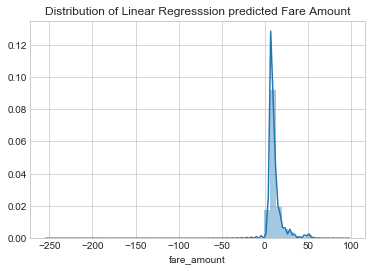

In [34]:
features = ['haversine_dist','longitude_diff', 'latitude_diff', 'passenger_count','day','month','hour','year','JFK_to_dropoff','JFK_to_pickup','LAGU_to_pickup','LAGU_to_dropoff','NEW_to_pickup','NEW_to_dropoff']

lin_reg.fit(X_train[features], y_train)

evaluate(lin_reg, X_train, X_valid, y_train, y_valid, features)

predictions = lin_reg.predict(test_copy[features])

submission = pd.DataFrame({'key': test_copy['key'], 'fare_amount': predictions})
submission.to_csv("sub_lin_reg_all_params.csv", index = False)

sns.distplot(submission['fare_amount'])
plt.title("Distribution of Linear Regresssion predicted Fare Amount");

#### c) Using the same feature set as (a) and replacing linear regression model with random forest using 20 estimators

In [35]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
features = ['haversine_dist','longitude_diff', 'latitude_diff', 'passenger_count','day','month','hour','year']

random_forest.fit(X_train[features], y_train)

evaluate(random_forest, X_train, X_valid, y_train, y_valid, features)

predictions = random_forest.predict(test_copy[features])

submission = pd.DataFrame({'key': test_copy['key'], 'fare_amount': predictions})
submission.to_csv("sub_ran_for_sub_params_20.csv", index = False)

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.0min finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   23.3s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    5.2s finished


Training:   rmse = 2.52
Validation: rmse = 3.51


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.1s finished


#### d) Same feature set as (c), change the estimators value in random forest to 100

In [36]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 100, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
features = ['haversine_dist','longitude_diff', 'latitude_diff', 'passenger_count','day','month','hour','year']

random_forest.fit(X_train[features], y_train)

evaluate(random_forest, X_train, X_valid, y_train, y_valid, features)

predictions = random_forest.predict(test_copy[features])

submission = pd.DataFrame({'key': test_copy['key'], 'fare_amount': predictions})
submission.to_csv("sub_ran_for_sub_params_100.csv", index = False)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 32.0min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   22.7s finished


Training:   rmse = 2.48
Validation: rmse = 3.47


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


#### e) Same feature process as (b) and using random forest model having estimators set to 20

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.4min finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   12.7s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.0s finished


Training:   rmse = 2.41
Validation: rmse = 3.18


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


Text(0.5,1,'Distribution of Random Forest predicted Fare Amount')

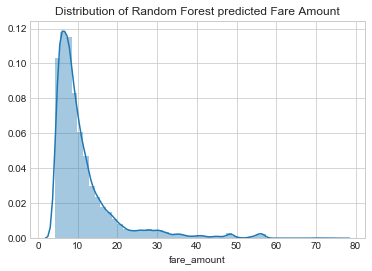

In [37]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
features = ['haversine_dist','longitude_diff', 'latitude_diff', 'passenger_count','day','month','hour','year','JFK_to_dropoff','JFK_to_pickup','LAGU_to_pickup','LAGU_to_dropoff','NEW_to_pickup','NEW_to_dropoff']

random_forest.fit(X_train[features], y_train)

evaluate(random_forest, X_train, X_valid, y_train, y_valid, features)

predictions = random_forest.predict(test_copy[features])

submission = pd.DataFrame({'key': test_copy['key'], 'fare_amount': predictions})
submission.to_csv("sub_ran_for_all_params_20.csv", index = False)

sns.distplot(submission['fare_amount'])
plt.title("Distribution of Random Forest predicted Fare Amount")
